## Client Convert-To-Paid (CTP) Prediction
The client (anonymized) is an ed-tech platform focused on personalized early learning for children ages 2-8. Using data collected on consumer trial periods (each trial spanning one month), our goal is to write a program that predicts whether a consumer will convert to a paid customer (CTP = 1) or not (CTP = 0) at the end of their free trial.

This code is 5-part:
1. Data Exploration
2. Data Preprocessing
3. Model Training and Evaluation
4. Project Conclusion
5. Tangential Analysis: Effect of Hyperparameters on Model Performance

This question was originally given to me as a job interview question a year ago. I passed the interview, but at the time I didn't thoroughly understand the code I wrote and a large part of it was superficially hacked together and copy-pasted from various snippets of code on the internet. I decided to re-do this project from scratch as an exercise in 1) becoming more comfortable in python, 2) learning to implement classification algorithms in code, and 3) understanding the mathematical underpinnings of these algorithms through visualization and experimentation.

In [132]:
#pandas / numpy for data analysis and manipulation, matplotlib / seaborn for visualization
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#sklearn modules for classification algorithms, hyperparameter tuning, and model performance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

dir(pd.options.display)
pd.options.display.max_columns = 50

In [2]:
#import dataset
client_data = pd.read_csv('client_clean.csv')

### 1. Data Exploration
- Investigate characteristics of the dataset, including distribution of features, size of the data, and baseline conversion rate (free trial to CTP)
- Establish the "baseline" accuracy we're going for - in other words, what % of people convert to paid in the first place? This is subsequently the accuracy we would achieve by guessing CTP = 1 all of the time (or CTP = 0 all of the time - whatever is majority). This is also the accuracy we will aim to beat with our model.
- Explore the relationships between categorical / continuous variables to the target variable. Findings are summarized below.

#### Categorical variables:
Categories that appear correlated to CTP:
- path_type (alc, pathways)
- completed category (high, very high)
- event_count_cat (high, very high)
- device cat (ipad)
- max_stage (C, D, E)
- weekly_visit_cat (high, very high)
- max_days_into_trial (> 20)
- distinct_weeks (4)
- distinct days (> 15)
- average_age_int (3-7)
- avg_level
- avg_cluster

Categories that appear uncorrelated to CTP:
- multi_user_label
- pop_event_day

#### Continuous variables:
Almost all continuous variables seem uncorrelated to CTP. max_days_into_trial, however, seems to have a clear relationship to CTP - higher values for the "max day reached" (i.e., day 20 out of 31 days of the month) correspond to a higher percent of converting to paid.

In [3]:
client_data.head(2)

,userid,path_type,multi_user_label,single_user,multiple_user,total_events,completed_count,completed_cat,not_completed_count,event_count_cat,device_cat,ipad_event,iphone_event,ipod_event,max_stage_complete,pathways_complete_rank,pathways_reach_rank,pathways_count,alc_count,average_age_int,max_stage,first_week,second_week,third_week,distinct_weeks,distinct_days,avg_weekly_visit,avg_daily_hrs,weekly_visit_cat,max_days_into_trial,avg_days_from_trial,trial_day,max_stage_num,avg_level,avg_cluster,avg_step,pop_event_day,pop_title,pop_category,distinct_titles,title_count_cat,max_row,max_column,avg_row,avg_col,ctp
0,-9.219518e+18,"alc, pathways",Single-user,1,0,36,25,med,8,medium,iPhone,0,36,0,A,121.0,211.0,9,27,NaN,A,1,1,1,3,6,9,0,medium,21,16,14,1.0,1.0,1.0,1.0,Saturday,Letter Hunt,GAM,24,high,1.0,25.0,1.0,9.0,1
1,-9.218149e+18,pathways,Single-user,1,0,5,4,low,0,low,iPhone,0,5,0,A,121.0,211.0,5,0,1.0,A,1,0,1,2,2,3,0,low,20,4,1,1.0,1.0,1.0,1.0,Sunday,Letter Hunt,NaN,2,low,NaN,NaN,NaN,NaN,0


In [4]:
client_data.describe()

,userid,single_user,multiple_user,total_events,completed_count,not_completed_count,ipad_event,iphone_event,ipod_event,pathways_complete_rank,pathways_reach_rank,pathways_count,alc_count,average_age_int,first_week,second_week,third_week,distinct_weeks,distinct_days,avg_weekly_visit,avg_daily_hrs,max_days_into_trial,avg_days_from_trial,trial_day,max_stage_num,avg_level,avg_cluster,avg_step,distinct_titles,max_row,max_column,avg_row,avg_col,ctp
count,5.834000e+03,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5263.000000,5281.000000,5834.000000,5834.000000,5400.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5281.000000,5539.000000,5281.000000,5539.000000,5834.000000,3.466000e+03,3466.000000,3459.000000,3466.000000,5834.000000
mean,2.896520e+16,0.686664,0.313336,76.456462,50.795680,22.748543,33.600103,42.673294,0.183065,450.696561,460.993941,52.477374,23.979088,4.370926,0.984745,0.418581,0.344361,2.062393,4.841104,25.489201,1.847103,13.122043,4.936921,7.557079,3.294073,2.553349,1.047340,4.024553,33.741001,-1.862770e+16,11.369013,3.195721,3.241777,0.677580
std,5.349841e+18,0.463889,0.463889,129.560791,79.699731,58.472953,103.347261,94.666740,6.184218,284.176825,280.201537,77.953686,79.335395,1.742342,0.122578,0.493369,0.475200,1.115581,4.759494,29.341279,2.920150,11.508560,5.473731,3.996430,1.188351,1.352938,0.258992,1.921381,39.809618,4.141409e+17,13.144738,2.603580,3.185256,0.467443
min,-9.219518e+18,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,111.000000,111.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-9.223372e+18,0.000000,0.000000,0.000000,0.000000
25%,-4.615946e+18,0.000000,0.000000,13.000000,8.000000,3.000000,0.000000,0.000000,0.000000,251.000000,251.000000,8.000000,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000,8.000000,0.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,2.000000,9.000000,2.000000e+00,3.000000,1.000000,1.000000,0.000000
50%,-3.989598e+16,1.000000,0.000000,36.000000,25.000000,8.000000,0.000000,10.000000,0.000000,351.000000,361.000000,26.000000,2.000000,5.000000,1.000000,0.000000,0.000000,2.000000,3.000000,17.000000,0.000000,12.000000,3.000000,8.000000,3.000000,2.000000,1.000000,4.000000,20.000000,5.000000e+00,7.000000,2.000000,2.000000,1.000000
75%,4.680110e+18,1.000000,1.000000,91.000000,62.000000,22.000000,21.000000,46.000000,0.000000,601.000000,601.000000,66.000000,16.000000,6.000000,1.000000,1.000000,1.000000,3.000000,6.000000,32.000000,3.000000,25.000000,8.000000,11.000000,4.000000,3.000000,1.000000,5.000000,43.000000,1.300000e+01,18.000000,4.000000,4.000000,1.000000
max,9.221033e+18,1.000000,1.000000,3416.000000,1948.000000,1578.000000,3416.000000,2615.000000,425.000000,1563.000000,1563.000000,1258.000000,2540.000000,9.000000,1.000000,1.000000,1.000000,4.000000,32.000000,683.000000,23.000000,31.000000,30.000000,14.000000,5.000000,11.000000,4.000000,14.000000,398.000000,2.800000e+01,105.000000,27.000000,40.000000,1.000000


In [5]:
#Calculate benchmark CTP rate
baseline = client_data['ctp'].value_counts()[1]/client_data['ctp'].value_counts().sum()
print(f'Baseline conversion is {baseline:.4f}')
uniqueusers = client_data['userid'].nunique()
print(f'Distinct users is {uniqueusers}')

Baseline conversion is 0.6776
Distinct users is 5834


In [6]:
#calculate conversion rates for CTP for every categorical variable
#visualize results to investigate relationships
def conversion_calc(df, column, plot=True):
    if plot:
        plt.rcParams['figure.figsize'] = (7,45)
        figure, axes = plt.subplots(len(categorical_columns))
    for i in range(0, len(categorical_columns)):
        category = column[i]
        grouped = df.groupby([category,'ctp'])[['ctp']].count().rename(columns={'ctp':'count'}).reset_index()
        grouped['total']=[grouped[grouped[category]==element]['count'].sum() for element in grouped[category]]
        grouped['conversion'] = grouped['count']/grouped['total']
        if plot:
            mypalette = (sns.cubehelix_palette(8, start=.5, rot=-.75))
            sns.barplot(grouped[category], grouped['conversion'], hue = grouped['ctp'], ax = axes[i], palette = {1:'#8bdab2',0:'#348fa7'}, alpha = 0.8)
            axes[i].title.set_text(column[i])
            axes[i].set_xlabel('')
            axes[i].legend(loc='upper left')
            figure.subplots_adjust(hspace = 0.37)
        else:
            return grouped

#visualize distribution of continuous variables, separated by CTP
def plot_continuous(df, continuous_columns):
    plt.rcParams['figure.figsize'] = [7, 40]
    figure, axes = plt.subplots(len(continuous_columns))
    for i in range (0, len(continuous_columns)):
        ctp_1 = df.loc[df['ctp']==1]
        ctp_0 = df.loc[df['ctp']==0]
        sns.distplot(ctp_0[continuous_columns[i]], hist = False, kde_kws={'shade':True}, ax = axes[i], color = '#348fa7')
        sns.distplot(ctp_1[continuous_columns[i]], hist = False, kde_kws={'shade':True}, ax = axes[i], color = '#8bdab2')
        axes[i].title.set_text(continuous_columns[i])
        axes[i].set_xlabel('')
        axes[i].legend([0,1],loc='upper left')
        figure.subplots_adjust(hspace = 0.37)

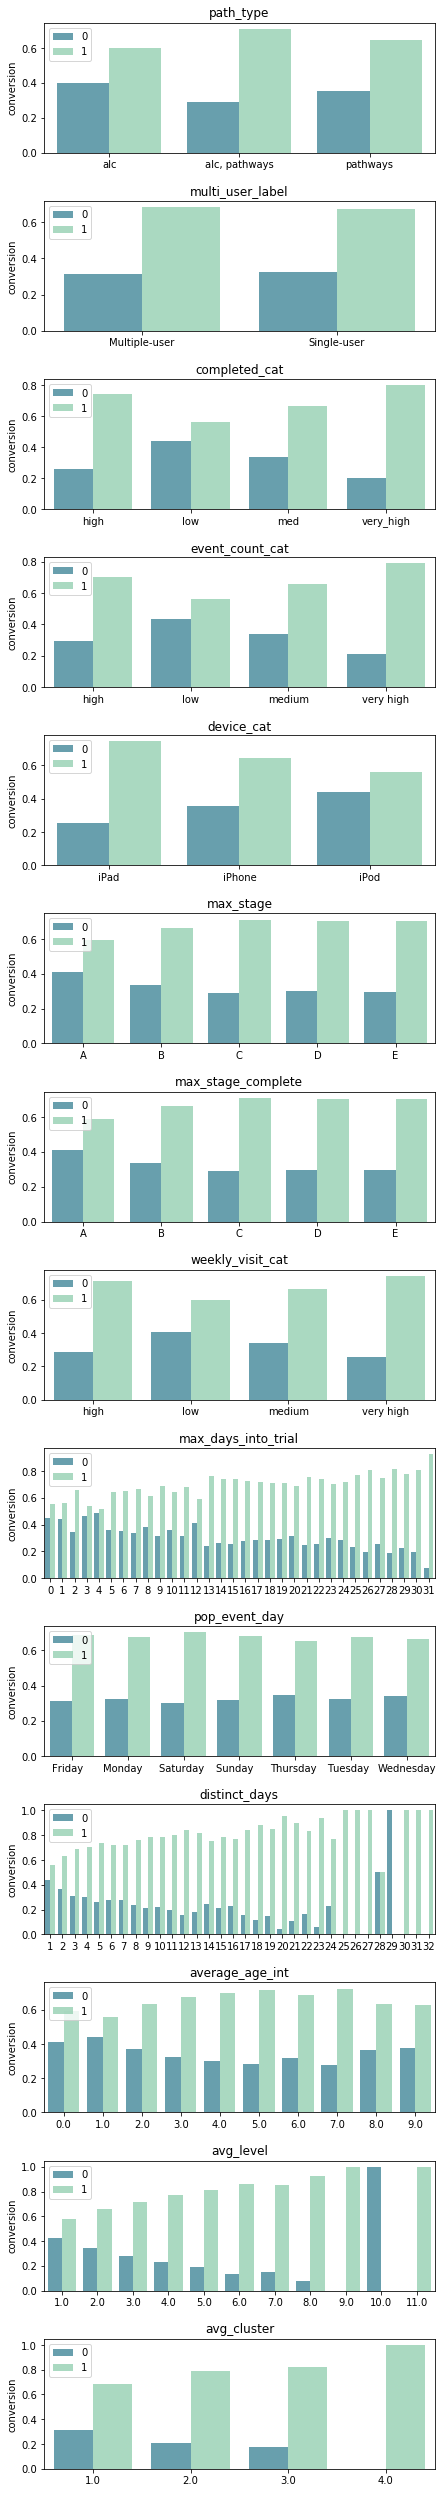

In [8]:
categorical_columns = ['path_type','multi_user_label','completed_cat','event_count_cat',
                      'device_cat','max_stage','max_stage_complete','weekly_visit_cat','max_days_into_trial','pop_event_day',
                      'distinct_days', 'average_age_int', 'avg_level','avg_cluster']

conversion_calc(client_data, categorical_columns, plot=True)

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


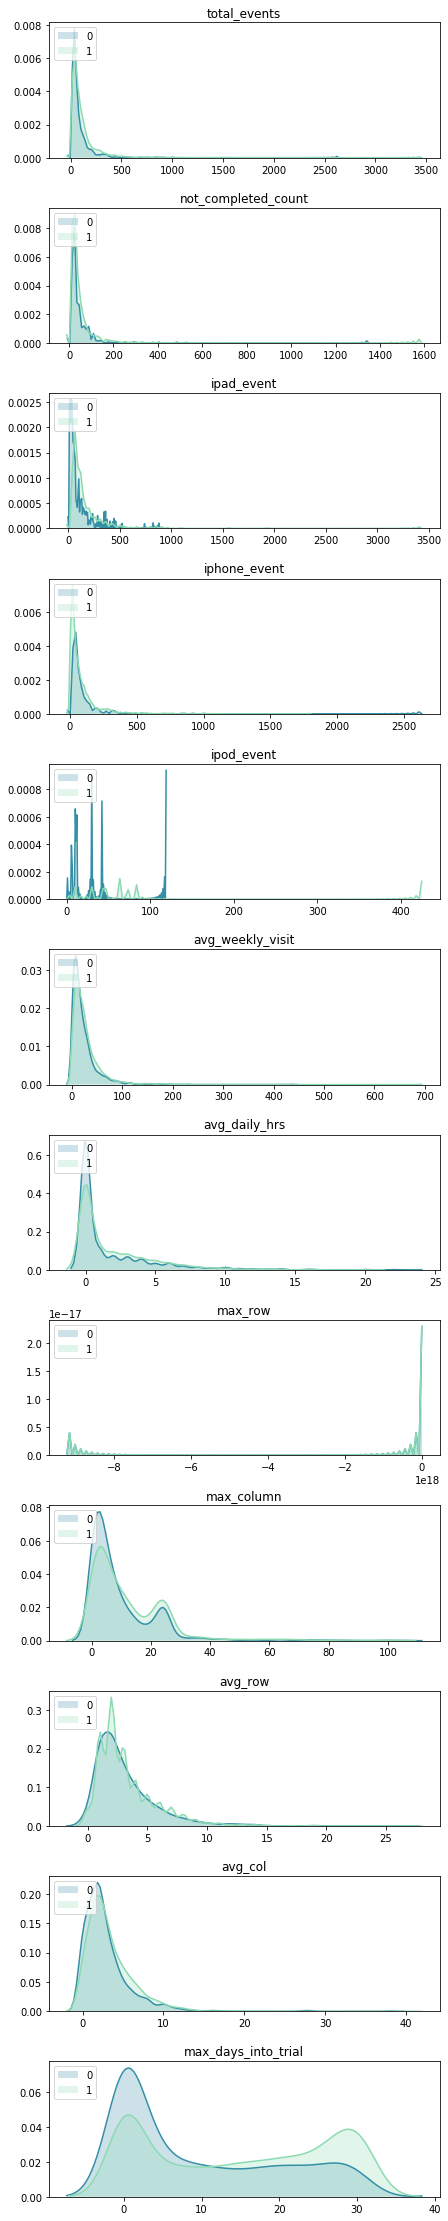

In [9]:
continuous_columns = ['total_events','not_completed_count','ipad_event','iphone_event','ipod_event','avg_weekly_visit',
                     'avg_daily_hrs','max_row','max_column','avg_row','avg_col','max_days_into_trial']

plot_continuous(client_data, continuous_columns)

### 2. Data Preprocessing
- Address NULL values.
- Make dummy variables for categorical variables.
- Create a feature that captures whether a user read one of the top 20 titles ("top" being defined as a title corresponding with a high CTP conversion rate).
- Note: Preprocessing on this dataset is limited since I originally cleaned and aggregated the original dataset (which I no longer have access to) in SQL; the client dataset loaded in this project is therefore the result of that processing.

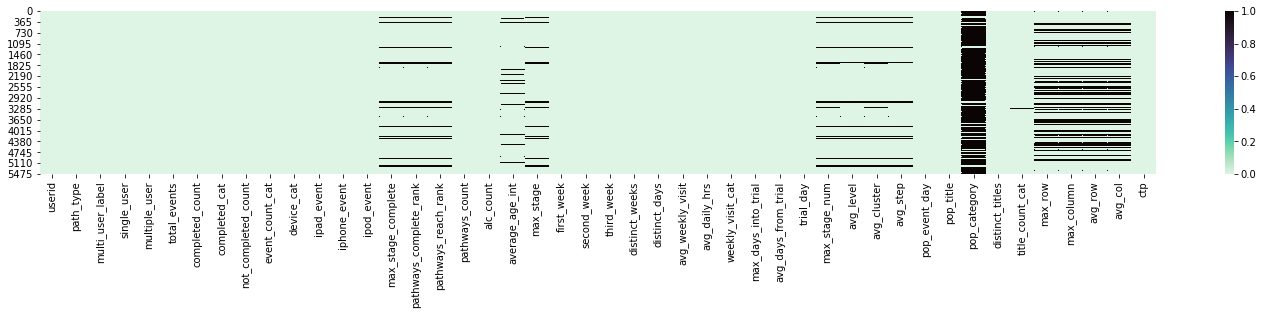

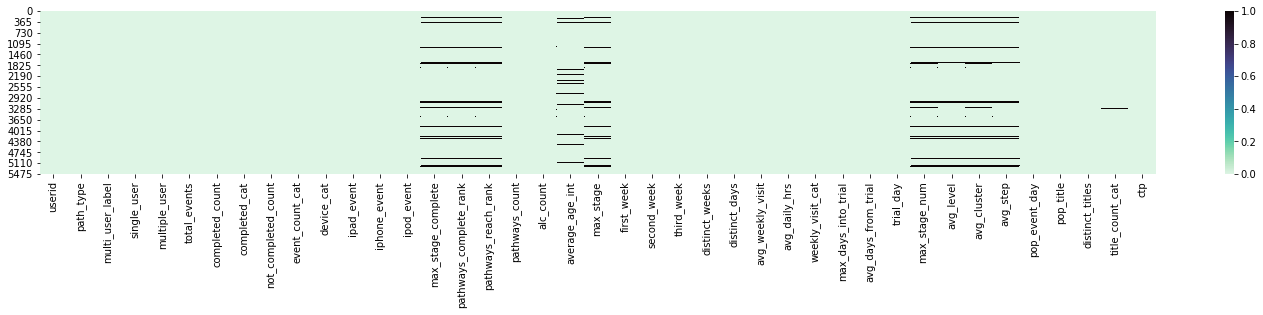

In [10]:
#Display missing values before and after removing unecessary columns
plt.rcParams['figure.figsize'] = (25,3)
mypalette = (sns.cubehelix_palette(8, start=.5, rot=-.75))
sns.heatmap(client_data.isnull(), cmap='mako_r')
plt.show()

#Since max_row, max_col, avg_row, avg_col don't seem to have strong correlation with CTP according to exploratory analysis, delete these columns
#pop_category is mostly missing, don't have a reasonable way to impute this - delete
client_clean = client_data.drop(['max_row','max_column','avg_row','avg_col','pop_category'],inplace = False, axis = 1)

sns.heatmap(client_clean.isnull(), cmap='mako_r')
plt.show()

#For now, drop any rows with null values - this could be improved with imputation methods in the future
client_nonull = client_clean.dropna().reset_index(drop = True)

In [11]:
#Calculate what the most commonly-read 20 titles are
#For these titles, find which ones have a conversion rate greater than our baseline of 67%. This indicates titles correlated with a high CTP rate

#75% of rows in dataset belong to top 20 titles
alltitles = pd.Series(client_nonull['pop_title'].unique())
top20titles = client_nonull['pop_title'].value_counts().nlargest(n=20).index
pop_titles = client_nonull[client_nonull['pop_title'].isin(top20titles)]
percent = pop_titles['pop_title'].value_counts().sum()/client_nonull.shape[0]
print(f'percent of total records with top 20 title: {percent}')

#Find the titles that have CTP conversion > baseline (67%)
title_conversions = conversion_calc(pop_titles, ['pop_title'], False)
best_titles = title_conversions[title_conversions['conversion'] > baseline]['pop_title'].to_list()
print('top 20 most popular titles with high conversion are:')
for element in best_titles:
    print('  -'+element)

percent of total records with top 20 title: 0.7576819962878945
top 20 most popular titles with high conversion are:
  -Angelina: Our Favorite Time of Year is Spring
  -Let's Draw
  -Memory Game: Friends
  -Power Practice
  -Same or Different
  -Sounds Abound
  -Speed Read
  -Teamwork!
  -What's That Sound?


In [12]:
#Get dummy columns for categorical variables and titles with high conversion (printed above)
dummy_columns = ['path_type','multi_user_label','device_cat','pop_event_day','pop_title']
repeat_categories = ['weekly_visit_cat','title_count_cat','event_count_cat','completed_cat',
                    'max_stage_complete','max_stage']
all_columns = dummy_columns + repeat_categories

#Add column name to low/med/high columns so dummy names for these columns are unique
for column in repeat_categories:
    client_nonull[column] = column + '_' + client_nonull[column]

#Merge dummy variables to continuous variables for final dataset
non_top_titles = list(alltitles[~alltitles.isin(best_titles)])
client_nonull['pop_title'] = client_nonull['pop_title'].replace(to_replace = list(non_top_titles),value = None)
client_nonull['pop_title'] = client_nonull['pop_title'].replace(non_top_titles,None)
client_nonull_dummies = pd.get_dummies(client_nonull[all_columns],prefix = 'cat')
client_nonull_noncat = client_nonull[[column for column in client_nonull.columns if column not in all_columns]]
final = pd.merge(client_nonull_dummies, client_nonull_noncat, left_index = True, right_index = True, how = 'outer')

In [13]:
#Confirm all types are numeric and there no nulls
print(final.dtypes.unique())
print(final.isnull().sum().unique())
print(final.columns)

[dtype('uint8') dtype('float64') dtype('int64')]
[0]
Index(['cat_alc, pathways', 'cat_pathways', 'cat_Multiple-user',
       'cat_Single-user', 'cat_iPad', 'cat_iPhone', 'cat_iPod',
       'cat_Friday   ', 'cat_Monday   ', 'cat_Saturday ', 'cat_Sunday   ',
       'cat_Thursday ', 'cat_Tuesday  ', 'cat_Wednesday',
       'cat_Angelina: Our Favorite Time of Year is Spring', 'cat_Let's Draw',
       'cat_Letter Hunt', 'cat_Memory Game: Friends', 'cat_Power Practice',
       'cat_Same or Different', 'cat_Sounds Abound', 'cat_Speed Read',
       'cat_Teamwork!', 'cat_What's That Sound?', 'cat_weekly_visit_cat_high',
       'cat_weekly_visit_cat_low', 'cat_weekly_visit_cat_medium',
       'cat_weekly_visit_cat_very high', 'cat_title_count_cat_high',
       'cat_title_count_cat_low', 'cat_title_count_cat_med',
       'cat_title_count_cat_very high', 'cat_event_count_cat_high',
       'cat_event_count_cat_low', 'cat_event_count_cat_medium',
       'cat_event_count_cat_very high', 'cat_complete

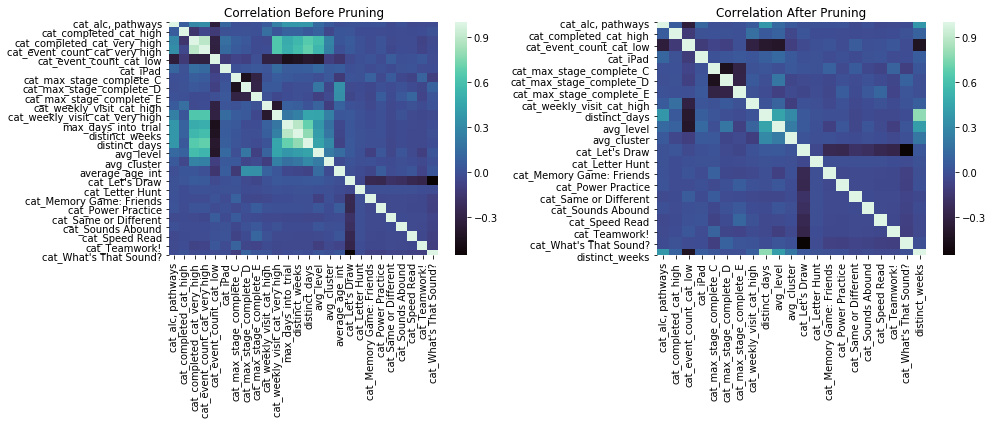

In [76]:
#Heatmap to visualize correlation among dependent variables
figure, subaxes = plt.subplots(1,2,figsize=(14,6))
sns.heatmap(final[['cat_alc, pathways', 'cat_completed_cat_high','cat_completed_cat_very_high','cat_event_count_cat_very high',
      'cat_event_count_cat_low','cat_iPad','cat_max_stage_complete_C', 'cat_max_stage_complete_D', 'cat_max_stage_complete_E',
      'cat_weekly_visit_cat_high','cat_weekly_visit_cat_very high', 'max_days_into_trial','distinct_weeks', 'distinct_days',
      'avg_level', 'avg_cluster', 'average_age_int', "cat_Let's Draw",
       'cat_Letter Hunt', 'cat_Memory Game: Friends', 'cat_Power Practice',
       'cat_Same or Different', 'cat_Sounds Abound', 'cat_Speed Read',
       'cat_Teamwork!', "cat_What's That Sound?"]].corr(), cmap='mako', ax=subaxes[0])
subaxes[0].set_title('Correlation Before Pruning')

#Heatmap to visualize correlation after removing variables that are highly correlated
#This is to prevent against multicollinearity, which can affect the calculation of individual predictors
sns.heatmap(final[['cat_alc, pathways', 'cat_completed_cat_high',
      'cat_event_count_cat_low','cat_iPad','cat_max_stage_complete_C', 'cat_max_stage_complete_D', 'cat_max_stage_complete_E',
      'cat_weekly_visit_cat_high','distinct_days',
      'avg_level', 'avg_cluster',  "cat_Let's Draw",
       'cat_Letter Hunt', 'cat_Memory Game: Friends', 'cat_Power Practice',
       'cat_Same or Different', 'cat_Sounds Abound', 'cat_Speed Read',
       'cat_Teamwork!', "cat_What's That Sound?",'distinct_weeks']].corr(), cmap = 'mako', ax = subaxes[1])
subaxes[1].set_title('Correlation After Pruning')
plt.tight_layout()
plt.show()

In [77]:
#Define final independent variables (X) and final dependent variable (y)
X=final[['cat_alc, pathways', 'cat_completed_cat_high',
      'cat_event_count_cat_low','cat_iPad','cat_max_stage_complete_C', 'cat_max_stage_complete_D', 'cat_max_stage_complete_E',
      'cat_weekly_visit_cat_high','distinct_days',
      'avg_level', 'avg_cluster',  "cat_Let's Draw",
       'cat_Letter Hunt', 'cat_Memory Game: Friends', 'cat_Power Practice',
       'cat_Same or Different', 'cat_Sounds Abound', 'cat_Speed Read',
       'cat_Teamwork!', "cat_What's That Sound?",'distinct_weeks']]
y = final['ctp']

### 3. Model Training and Evaluation
- Create a class to split the dataset into train/test sets, normalize the data, and fit various classification models
- We split the data into train/test sets so that we have one collection to fit our model on and preserve another set to make predictions and evaluate model accuracy. We also normalize the data since many classifications are sensitive to the distribution of features
- Models include: K-Nearest Neighbors, Logistic Regression, Random Forest, and Support Vector Machine
- Each method that fits a model uses grid search to tune hyperparameters and find the model with the best fit (random search would be faster and probably just as effective, but we use grid search - which will test more parameters - so that we can more thoroughly investigate the effect of parameters on performance in Section 5). They also have the functionality to return a df with the parameters and the accuracy score of all models trained during the random search to allow for investigation into how each of the parameters affect model results.

In [139]:
class Model:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test, self.X_train_scaled, self.X_test_scaled = self.split_scale_data()
        
        
    def split_scale_data(self):
        X=self.X
        y=self.y
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return (X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)
        
        
    def rs_knn(self, scaled=True, df=False):
        X_train = self.X_train
        X_test = self.X_test
        X_train_scaled = self.X_train_scaled
        X_test_scaled = self.X_test_scaled
        y_train = self.y_train
        y_test = self.y_test
    
        knn_results = []
        knn = KNeighborsClassifier()
        params_knn = [{'weights':['uniform','distance'],
                  'n_neighbors':range(1,15),
                      'n_jobs':[None, -1,2]}]
        rs_knn = GridSearchCV(knn, param_grid = params_knn, cv = 5)
        if scaled:
            rs_knn.fit(X_train_scaled, y_train)
            knn_results=['KNN',KNeighborsClassifier(),rs_knn.best_params_, rs_knn.best_score_]
            if df:
                knn_df = pd.DataFrame(rs_knn.cv_results_).iloc[:,4:]
            else:
                knn_df = None
        else:
            rs_knn.fit(X_train, y_train)
            knn_results=['KNN',KNeighborsClassifier(),rs_knn.best_params_, rs_knn.best_score_]
            if df:
                knn_df = pd.DataFrame(rs_knn.cv_results_).iloc[:,4:]
            else:
                knn_df = None
        return knn_results, knn_df

    
    def rs_logistic(self, scaled=True, df=False):
        X_train = self.X_train
        X_test = self.X_test
        X_train_scaled = self.X_train_scaled
        X_test_scaled = self.X_test_scaled
        y_train = self.y_train
        y_test = self.y_test
    
        log_results = []
        log = LogisticRegression()
        params_log = [{'penalty':['l2'],
                  'C':[10**n for n in range (-10,10)],
                      'max_iter':[100, 200, 300,400],
                      'solver':['lbfgs', 'liblinear']},
                     {'penalty':['l1'],
                  'C':[10**n for n in range (-10,10)],
                      'max_iter':[100, 200, 300,400,500],
                      'solver':['liblinear']}]
 
        rs_log = GridSearchCV(log, param_grid = params_log)
        if scaled:
            rs_log.fit(X_train_scaled, y_train)
            log_results=['Logistic Regression',LogisticRegression(),rs_log.best_params_, rs_log.best_score_]
            if df:
                log_df = pd.DataFrame(rs_log.cv_results_).iloc[:,4:]
            else:
                log_df = None
        else:
            rs_log.fit(X_train, y_train)
            log_results=['Logistic Regression',LogisticRegression(),rs_log.best_params_, rs_log.best_score_]
            if df:
                log_df = pd.DataFrame(rs_log.cv_results_).iloc[:,4:]
            else:
                log_df = None
        return log_results, log_df
    
    
    #note: you don't have to scale data with random forests, but a universal transformation of all features should not affect model results
    #we scale the data for consistency in later functions, which use scaled data to calculate model performance
    def rs_randomforest(self, df=False):
        X_train = self.X_train
        X_test = self.X_test
        X_train_scaled = self.X_train_scaled
        X_test_scaled = self.X_test_scaled
        y_train = self.y_train
        y_test = self.y_test
    
        rf_results = []
        rf = RandomForestClassifier()
        params_rf = [{'n_estimators':[100,200,300,400,500],
                       'criterion':['gini', 'entropy'],
                       'max_depth':[3,5,8,10,15,None],
                       'bootstrap':[True, False]}]
        rs_randomforest = GridSearchCV(rf, param_grid = params_rf)
        rs_randomforest.fit(X_train, y_train)
        rf_results = ['Random Forest',RandomForestClassifier(),rs_randomforest.best_params_, rs_randomforest.best_score_]
        if df:
            rf_df = pd.DataFrame(rs_randomforest.cv_results_).iloc[:,4:]
        else:
            rf_df = None
        return rf_results, rf_df

In [140]:
#Use random search to find the best KNN model, logistic classifier, and random forest
mymodel = Model(X,y)
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = mymodel.split_scale_data()
knn_results, knn_df = mymodel.rs_knn(scaled=True, df=True)
log_results, log_df = mymodel.rs_logistic(scaled=True, df=True)
rf_results, rf_df = mymodel.rs_randomforest(df=True)

In [141]:
#Plot the confusion matrix and calculate the f1_score to compare the accuracy between models
#F1 score is a measure of how accurate the model is, taking into account how often it is able to accurately predict classes with low occurance - in this case, CTP = 0
def model_comparison(**kwargs):
    scores = {}
    figure, subaxes = plt.subplots(1,len(kwargs), figsize = (9,3))
    for i, (k, v) in enumerate(kwargs.items()):
        model_name = k
        model_type = v[1]
        model_fit = model_type.set_params(**v[2]).fit(X_train_scaled, y_train)
        score = model_fit.score(X_test_scaled, y_test)
        y_predicted = model_fit.predict(X_test_scaled)
        f1 = f1_score(y_test, y_predicted)
        plot_confusion_matrix(model_fit, X_test_scaled, y_test, ax=subaxes[i], cmap='mako_r',normalize='all')
        subaxes[i].set_title(v[0])
        if v[0] == 'Logistic Regression':
            scores[v[0]] = (f1, score, model_fit.coef_[0])
        elif v[0] == 'Random Forest':
            scores[v[0]]=(f1, score, model_fit.feature_importances_)
        else:
            scores[v[0]]=(f1, score)
        print(f'{v[0]}: f1_score is {f1:.4f}, accuracy is {score:.4f}')
    plt.tight_layout()
    plt.show()
    return scores

#Plot the rankings of features for Logistic Regression and Random Forest (KNN doesn't have rankings)
#Use this to understand which characteristics are necessary / unnecessary in a model, and improve models in future iterations
def plot_importances(scores):
    figure, subplots = plt.subplots(1,2, figsize=(10,5))
    test = pd.DataFrame(list(zip(X_train.columns,scores['Random Forest'][2])), columns=['column','coef']).sort_values('coef', ascending=False)
    test_log = pd.DataFrame(list(zip(X_train.columns,scores['Logistic Regression'][2])), columns=['column','coef']).sort_values('coef', ascending=False)

    sns.barplot(test['coef'],test['column'], ax=subplots[0], palette='mako_r')
    subplots[0].set_title('RF Feature Ranking')
    sns.barplot(test_log['coef'],test_log['column'], ax=subplots[1], palette='mako_r')
    subplots[1].set_title('Logistic Feature Ranking')
    plt.tight_layout()

KNN: f1_score is 0.7788, accuracy is 0.6595
Logistic Regression: f1_score is 0.8218, accuracy is 0.6974
Random Forest: f1_score is 0.8220, accuracy is 0.6983


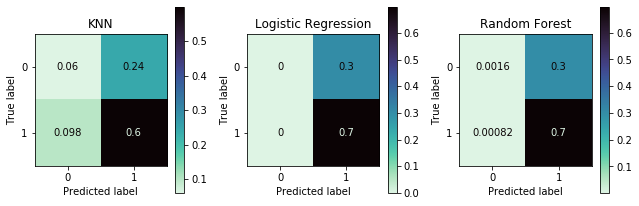

In [142]:
scores = model_comparison(**{'knn':knn_results, 'log':log_results, 'rf':rf_results})

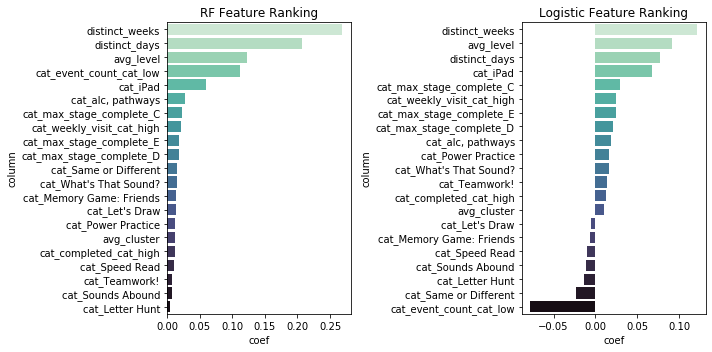

In [143]:
plot_importances(scores)

### 4. Project Conclusion
- Random forest is the best model for this problem, with an F1 score of 82%
- However, the model's naked accuracy is 70%, which is only incrementally better than our baseline of 67%
- Features that are most predictive of CTP are the maximum day a customer used the platform, the average number of days a customer logged into the platform, the distinct number of titles a customer read, the average level a customer reached, and the distinct number of days someone logged in.
- Possible improvements to this model include:
    - Using imputation methods to calculate missing values
    - Improved feature engineering: further investigate relationship of features to others, narrow down which features to include or to augment with related data
    - Using other classification techniques: XGBoost, LGBM classification
    - Augmenting with more demographic data about the consumer: geographic location, interests, gender, homeschooled or public / private school, etc
    - Possible segmentation of models depending on consumer characteristics, like time the trial started (perhaps more likely to CTP in summer months, when school is off?), age (separate by those in school (4 yrs +) and those not in school (2-3 years)

### 5. Tangential Analysis: Effect of Hyperparameters on Model Performance
I was curious as to how the various parameters for each model affect the overall model performance. Though these observations may only apply to this dataset in particular, I wanted to gain a general understanding of how drastically each of these parameters impact model fit, and how that sensitivity varies model to model. Summary of findings below.

#### KNN:
- In general, model accuracy increases as the number of neighbors used increases. If we were to graph this for accuracy on the training set, however, we might see a decline in accuracy after a certain threshold in number of neighbors.
- Using a uniform weight (in which neighbors are not weighted by their distance to the query point) yields higher average test score, but with greater variance - as model score is lower for those with an even number of neighbors (possibly due to ties in who the nearest neighbors are).
- The number of jobs doesn't impact model performance.

#### Logistic Regression:
- For both L1 Penalty (Lasso regression) and L2 Penalty (Ridge regression), the C parameter (higher C values = less severe penalization) has a strong effect on model performance.
- With L1 regularization, model performance increases significantly after C >= 0.01. The goal with Lasso regression is to prune insignificant variables - but values of C < 0.01 take this too far, discluding ALL features. Once C increases past 0.01, more features are included in the model, but they add low marginal improvement to the overall score.
- With L2 regularization, model performance is highly variable until C >=1, where scores converge to ~70%.
- The number of maximum iterations doesn't impact scores for Lasso regression or Ridge regression. However, the latter model has different performance depending on what type of solver is used - 'lgbfs' has higher scores and lower variability. I don't yet understand the difference between the solver types - need to look into this more.

#### Random Forest:
- The number of estimators does not have a signifcant impact on model performance.
- There's a slight impact on performance from bootstrapping, which slightly increases accuracy and decreases variability in model scores.
- As the depth of the three increases, the model performance decreases. Using the 'entropy' criteria and bootstrapping the samples increases score.

#### K-Nearest Neighbors

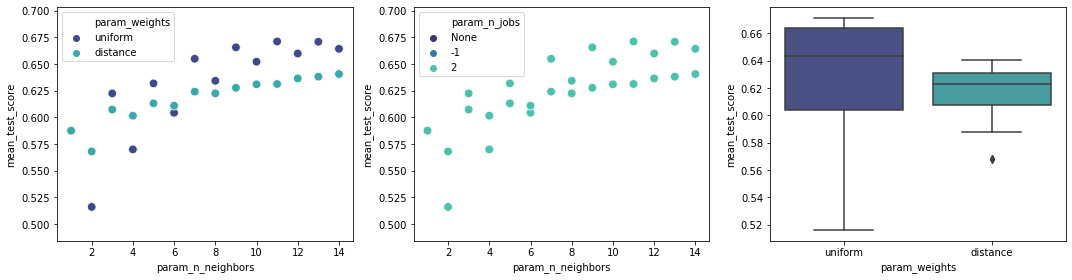

In [245]:
#How does the weighting metric, the number of neighbors, and the number of jobs affect KNN performance?
figure, subaxes = plt.subplots(1,3,figsize=(15,4))
sns.scatterplot(knn_df['param_n_neighbors'], knn_df['mean_test_score'], hue=knn_df['param_weights'],s=75,palette='mako', ax=subaxes[0])
sns.scatterplot(knn_df['param_n_neighbors'], knn_df['mean_test_score'], hue=(knn_df['param_n_jobs']).apply(str),s=75,palette='mako', ax=subaxes[1])
sns.boxplot(knn_df['param_weights'], knn_df['mean_test_score'],palette='mako', ax=subaxes[2])

plt.tight_layout()

#### Logistic Regression

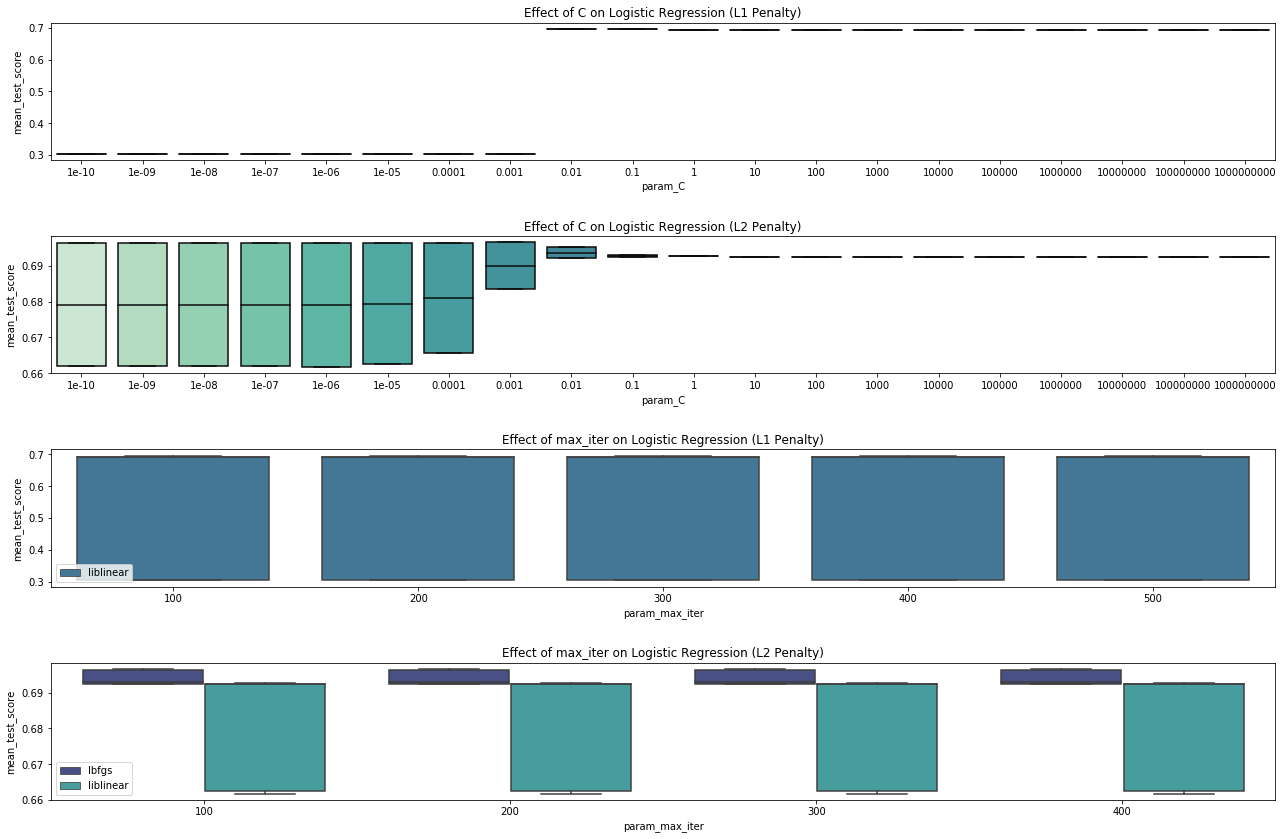

In [246]:
#How does the value of C affect performance for each of the two penalty types?
figure, subaxes=plt.subplots(4,1,figsize = (18,12))
l1 = log_df[log_df['param_penalty'] == 'l1']
sns.boxplot(l1['param_C'], l1['mean_test_score'],palette='mako_r',ax=subaxes[0])
subaxes[0].set_title('Effect of C on Logistic Regression (L1 Penalty)')

l2 = log_df[log_df['param_penalty'] == 'l2']
sns.boxplot(l2['param_C'], l2['mean_test_score'],palette='mako_r', ax=subaxes[1])
subaxes[1].set_title('Effect of C on Logistic Regression (L2 Penalty)')

#ow does the value of max_iter affect performance for each of the two penalty types?
sns.boxplot(l1['param_max_iter'], l1['mean_test_score'],hue = l1['param_solver'],palette='mako',ax = subaxes[2])
subaxes[2].legend(loc='lower left')
subaxes[2].set_title('Effect of max_iter on Logistic Regression (L1 Penalty)')
sns.boxplot(l2['param_max_iter'], l2['mean_test_score'],hue = l2['param_solver'],palette='mako', ax=subaxes[3])
subaxes[3].legend(loc='lower left')
subaxes[3].set_title('Effect of max_iter on Logistic Regression (L2 Penalty)')
figure.subplots_adjust(hspace = 10)
plt.tight_layout()

#### Random Forest

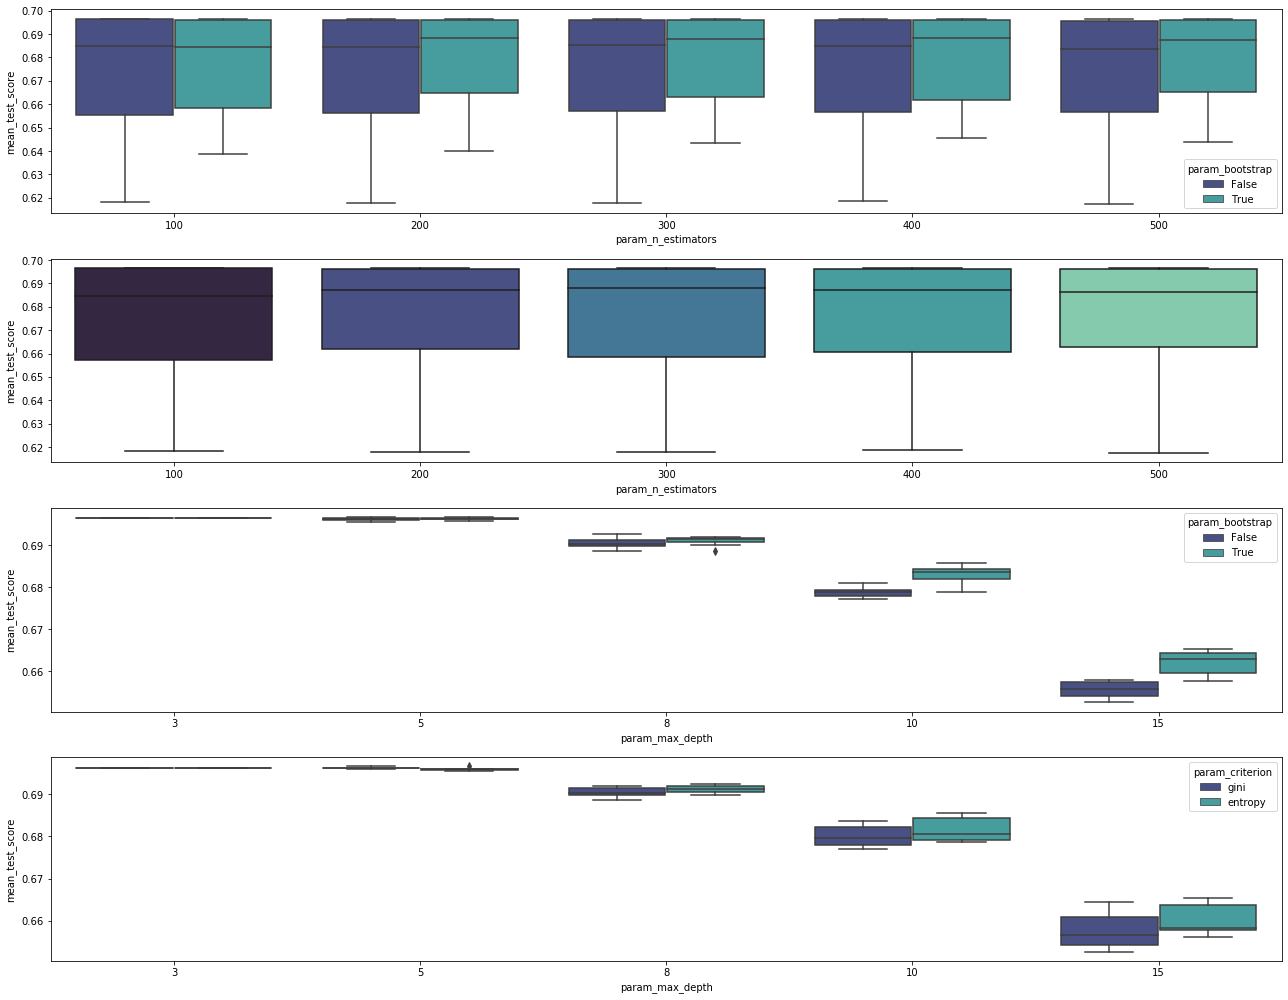

In [248]:
#How does the number of estimators, the depth of the tree, the bootstrap method, and the criterion method impact model performance?
figure, subaxes = plt.subplots(4,1,figsize=(18,14))
sns.boxplot(rf_df['param_n_estimators'], rf_df['mean_test_score'], hue=rf_df['param_bootstrap'], palette='mako', ax=subaxes[0])
sns.boxplot(rf_df['param_n_estimators'], rf_df['mean_test_score'], palette='mako', ax=subaxes[1])
sns.boxplot(rf_df['param_max_depth'], rf_df['mean_test_score'], rf_df['param_bootstrap'],palette='mako', ax=subaxes[2])
sns.boxplot(rf_df['param_max_depth'], rf_df['mean_test_score'], rf_df['param_criterion'],palette='mako', ax=subaxes[3])
plt.tight_layout()